# Pump it Up: Data Mining the Water Table

Pump it Up: This is a Driven Data competition done using data from Taarifa and the Tanzanian Ministry of Water where the objective is to predict which water pumps are functional or need repairs. It was done as a group assignment as part of our Machine Learning II coursework using Python.

# Importing Libraries and the Data

In [1]:
# Importing libraries
import warnings
warnings.simplefilter(action='ignore')
from dataset import Dataset
from collections import Counter
from copy import copy, deepcopy
from gplearn.genetic import SymbolicTransformer
import pandas as pd
import numpy as np
from tqdm import tnrange, tqdm_notebook, tqdm
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns; sns.set()
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cluster import DBSCAN
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score, train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, make_scorer, f1_score, recall_score, matthews_corrcoef, precision_score, classification_report, confusion_matrix
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from matplotlib import pyplot
from sklearn.utils.validation import column_or_1d
from sklearn.decomposition import PCA
import xgboost as xgb

In [2]:
# Loading the 3 data sets: Train Values (the variables we are going to use to predict), Train Labels (Target variable) 
# and the Test Values (that is the data we are going to use to test our final model and predict)

TrainV = Dataset('TrainValues.csv')
TrainL = Dataset('TrainLabels.csv')
TestV= Dataset('TestValues.csv')
SubFormat= Dataset('SubmissionFormat.csv')

print("Train Values Names:" + str(TrainV.names()))
print("Train Labels Names:" + str(TrainL.names()))
print("Test Values Names:" + str(TestV.names()))

Train Values Names:['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
Train Labels Names:['id', 'status_group']
Test Values Names:['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 

In [3]:
# Creating a dataset joining the Train Values dataset and the Train Labels dataset.
TrainWater = copy(TrainV).add_columns(TrainL.features["status_group"])
print("Train Water Names:" + str(TrainWater.names()))

Train Water Names:['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [4]:
# Setting the target variable
TrainWater.set_target('status_group')

# Exploratory Data Analysis

In [80]:
# Cheking for numerical variables
TrainWater.features[TrainWater.numerical_features]

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
0,69572.0,6000.0,1390.0,34.938093,-9.856322,0.0,11.0,5.0,109.0,1999.0
1,8776.0,0.0,1399.0,34.698766,-2.147466,0.0,20.0,2.0,280.0,2010.0
2,34310.0,25.0,686.0,37.460664,-3.821329,0.0,21.0,4.0,250.0,2009.0
3,67743.0,0.0,263.0,38.486161,-11.155298,0.0,90.0,63.0,58.0,1986.0
4,19728.0,0.0,0.0,31.130847,-1.825359,0.0,18.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
59395,60739.0,10.0,1210.0,37.169807,-3.253847,0.0,3.0,5.0,125.0,1999.0
59396,27263.0,4700.0,1212.0,35.249991,-9.070629,0.0,11.0,4.0,56.0,1996.0
59397,37057.0,0.0,0.0,34.017087,-8.750434,0.0,12.0,7.0,0.0,0.0
59398,31282.0,0.0,0.0,35.861315,-6.378573,0.0,1.0,4.0,0.0,0.0


<Figure size 1008x432 with 0 Axes>

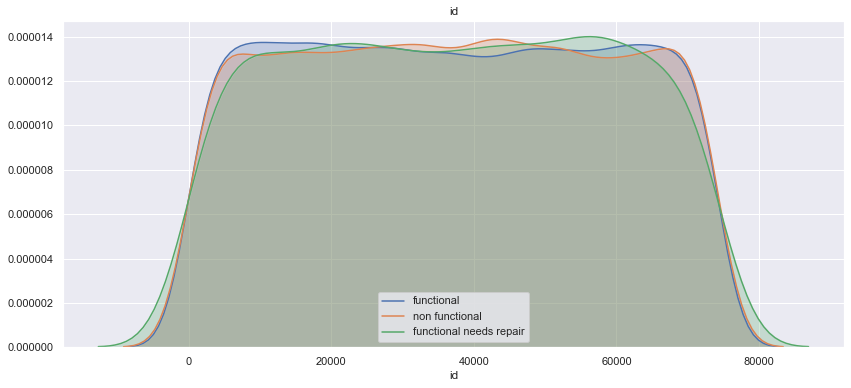

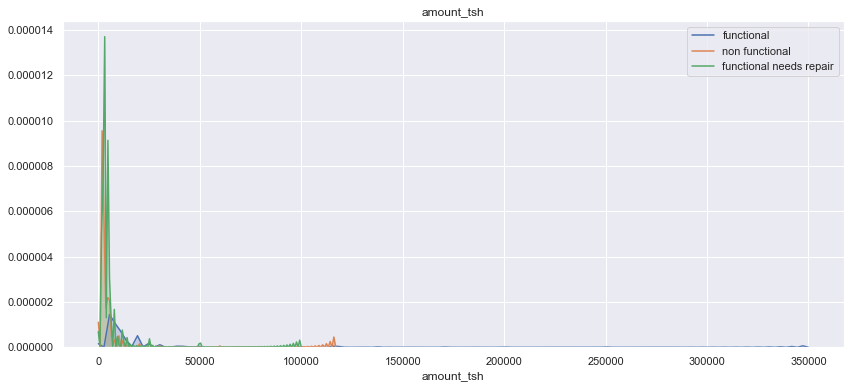

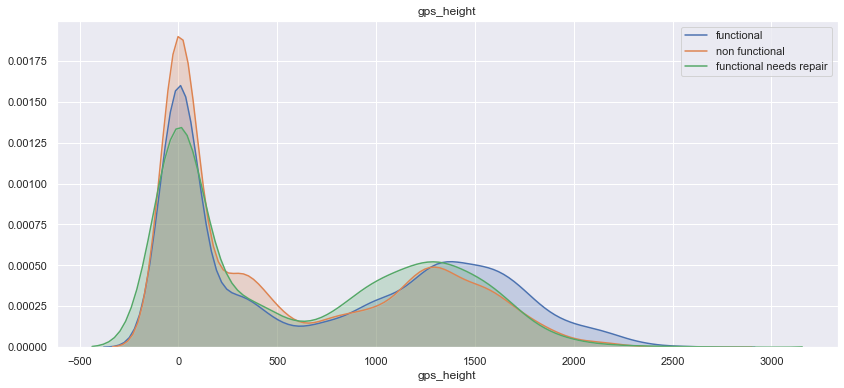

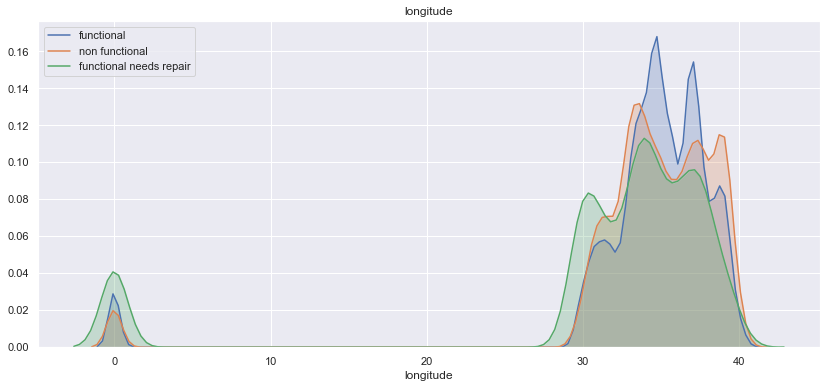

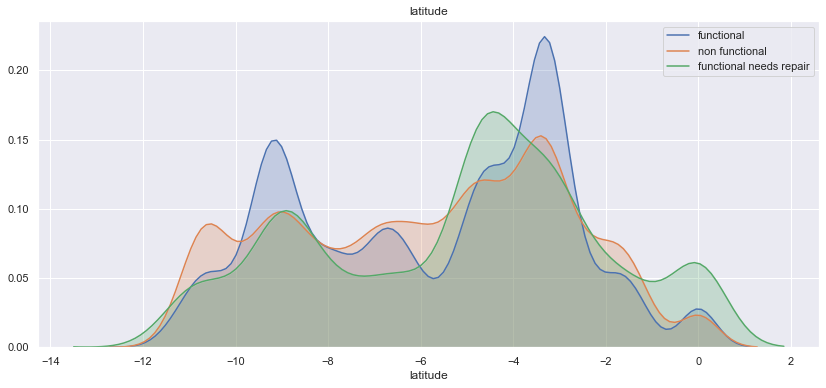

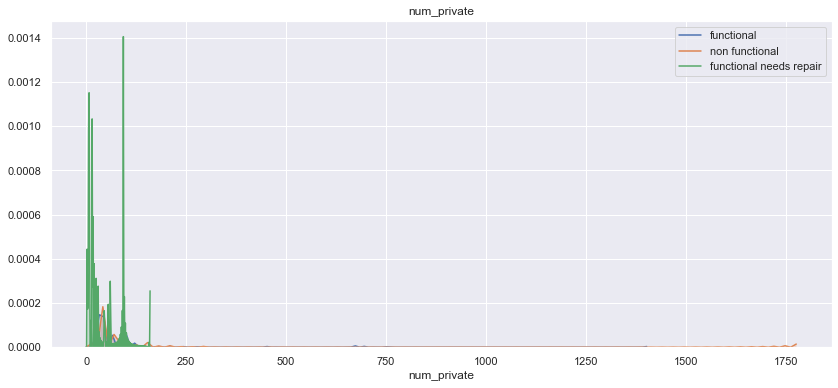

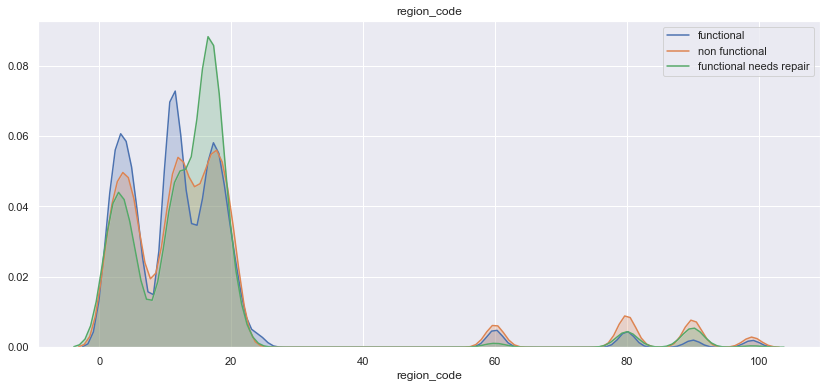

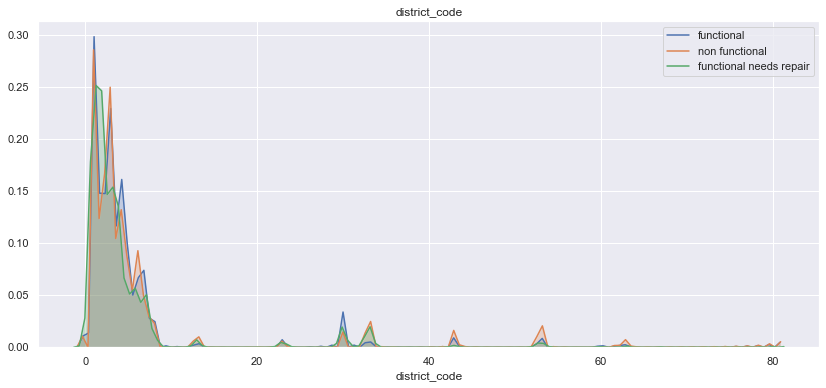

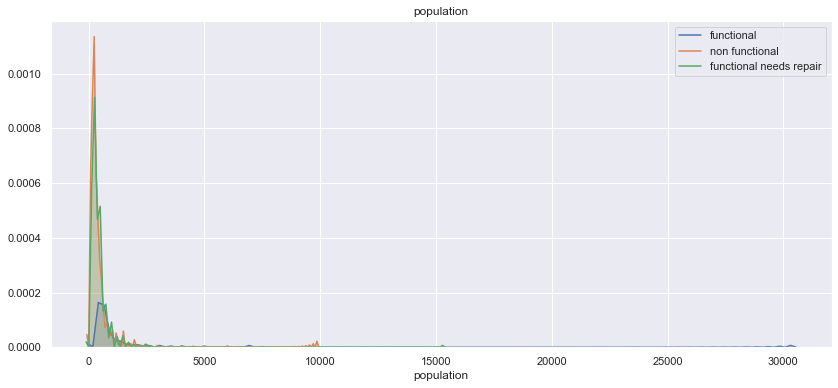

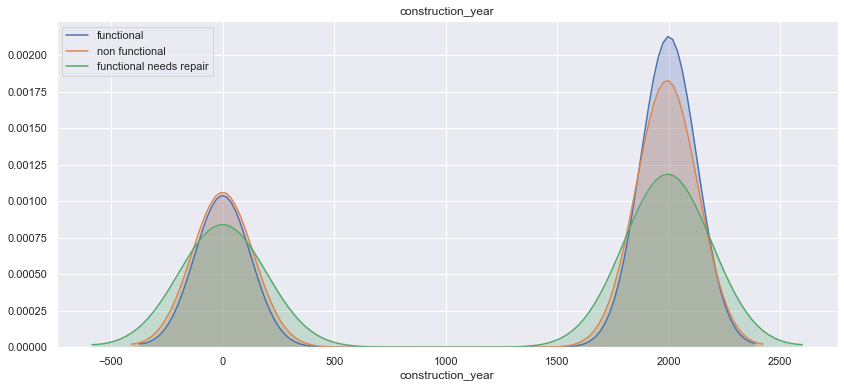

In [6]:
# Making density plots
plt.figure(figsize=(14, 6))
num_plots = len(list(TrainWater.numerical))
for index, feature in enumerate(list(TrainWater.numerical)):
    plt.figure(figsize=(14, 6))
    TrainWater.plot_density(feature)
    plt.legend(loc='best'); plt.ylabel('');
    plt.title(feature)
plt.show();

In [ ]:
# Checking correlation between numerical variables
df.numerical_correlated()[1]

In [9]:
# Checking for unique values of categorical variables
for i in TrainWater.categorical_features:
    print(i + " " + str(len(TrainWater.features[i].unique())) + " unique values")   

date_recorded 356 unique values
funder 1898 unique values
installer 2146 unique values
wpt_name 37400 unique values
basin 9 unique values
subvillage 19288 unique values
region 21 unique values
lga 125 unique values
ward 2092 unique values
public_meeting 3 unique values
recorded_by 1 unique values
scheme_management 13 unique values
scheme_name 2697 unique values
permit 3 unique values
extraction_type 18 unique values
extraction_type_group 13 unique values
extraction_type_class 7 unique values
management 12 unique values
management_group 5 unique values
payment 7 unique values
payment_type 7 unique values
water_quality 8 unique values
quality_group 6 unique values
quantity 5 unique values
quantity_group 5 unique values
source 10 unique values
source_type 7 unique values
source_class 3 unique values
waterpoint_type 7 unique values
waterpoint_type_group 6 unique values


In [5]:
# Dropping categorical values that have a large number of unique values because they don't add any value 
# to the model to predict
TrainWater.drop_columns(["date_recorded", "funder", "installer", "wpt_name", "subvillage", "ward",
                         "scheme_name", "lga"])

In [82]:
# Checking the categorical variables
TrainWater.features[TrainWater.categorical_features]

,basin,region,public_meeting,recorded_by,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,Lake Nyasa,Iringa,True,GeoData Consultants Ltd,VWC,False,gravity,gravity,gravity,vwc,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,Lake Victoria,Mara,NaN,GeoData Consultants Ltd,Other,True,gravity,gravity,gravity,wug,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,Pangani,Manyara,True,GeoData Consultants Ltd,VWC,True,gravity,gravity,gravity,vwc,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,Ruvuma / Southern Coast,Mtwara,True,GeoData Consultants Ltd,VWC,True,submersible,submersible,submersible,vwc,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,Lake Victoria,Kagera,True,GeoData Consultants Ltd,NaN,True,gravity,gravity,gravity,other,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,Pangani,Kilimanjaro,True,GeoData Consultants Ltd,Water Board,True,gravity,gravity,gravity,water board,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,Rufiji,Iringa,True,GeoData Consultants Ltd,VWC,True,gravity,gravity,gravity,vwc,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,Rufiji,Mbeya,True,GeoData Consultants Ltd,VWC,False,swn 80,swn 80,handpump,vwc,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,Rufiji,Dodoma,True,GeoData Consultants Ltd,VWC,True,nira/tanira,nira/tanira,handpump,vwc,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


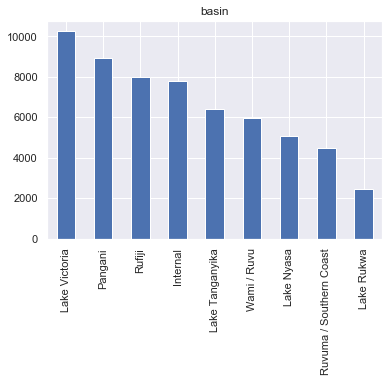

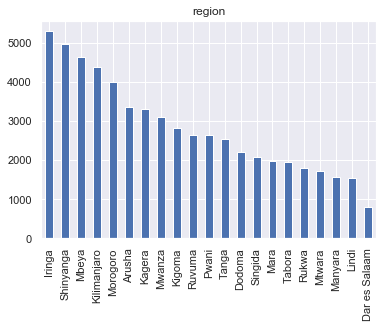

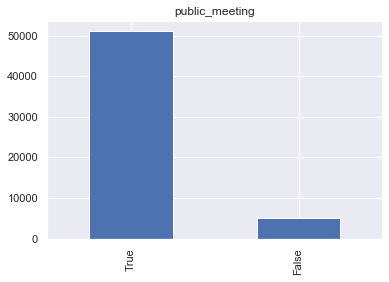

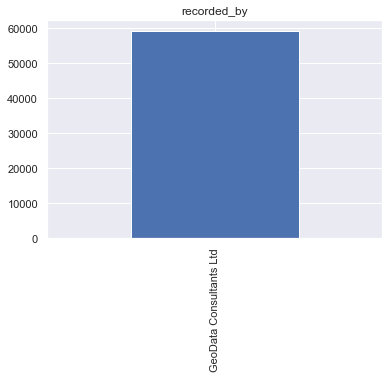

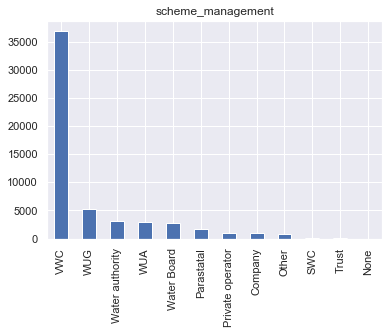

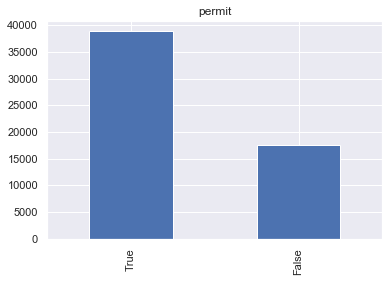

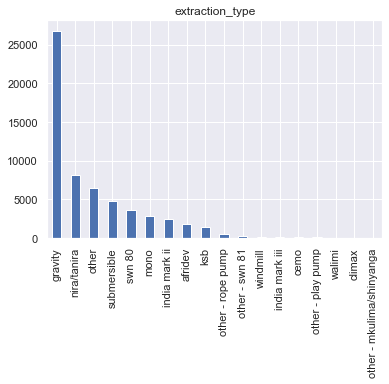

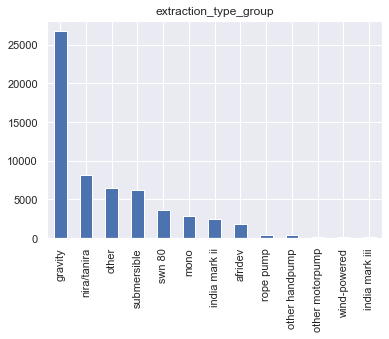

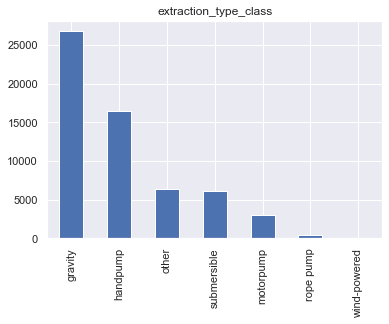

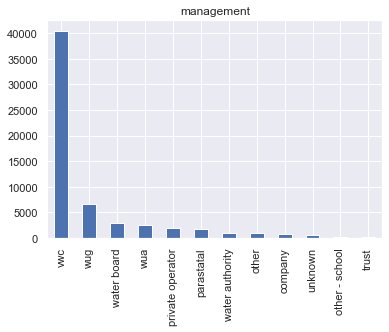

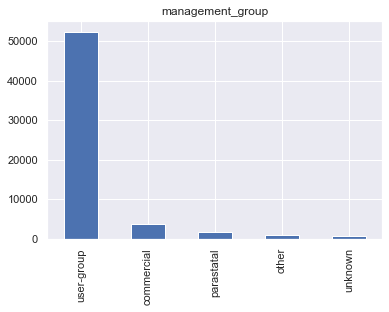

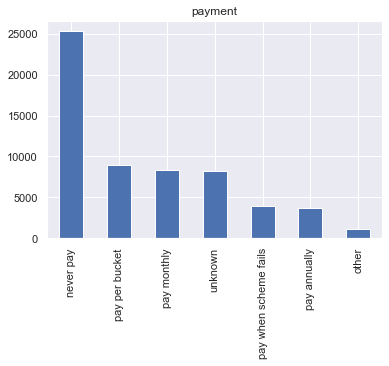

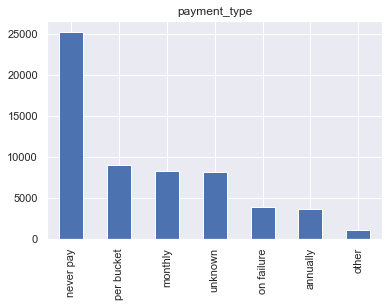

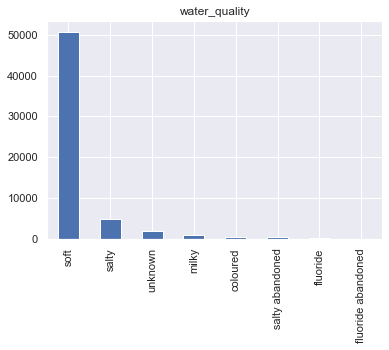

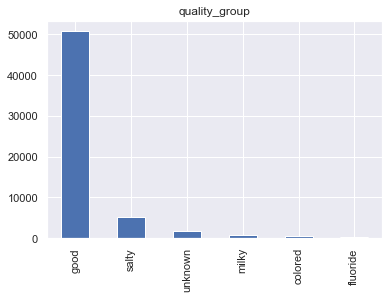

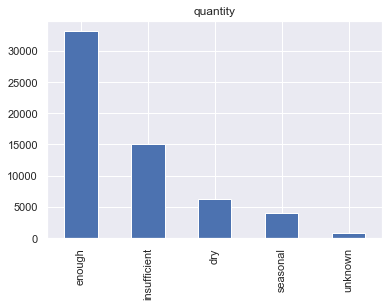

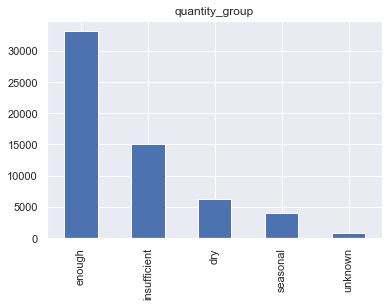

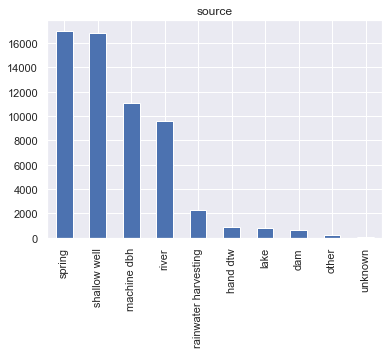

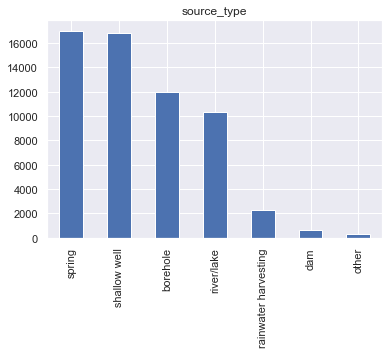

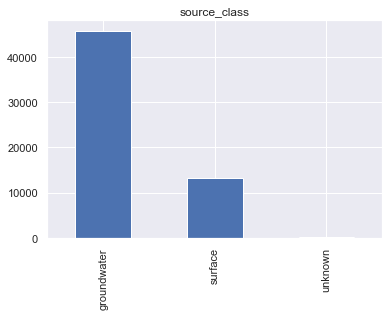

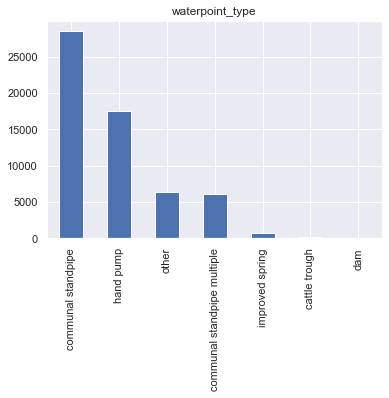

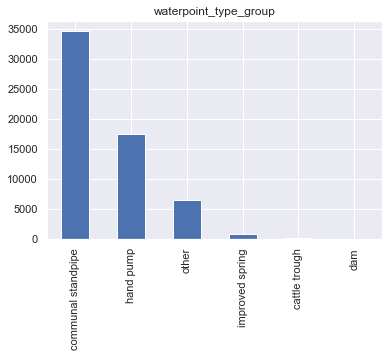

In [11]:
# Looking for the distribution of the categorical variables to have a better understanding of the data.
for i in TrainWater.categorical_features:
    TrainWater.features[i].value_counts().plot(kind='bar')
    plt.title(i)
    plt.show()

# Defining functions

In [114]:
# This function as its name indicates evaluates the Test and Train accuracy score of a model with CV
scores = []

def evaluate(df, estimator, store=True, verbose=False):
    X, y = df.split()

    estimator.fit(X.train, y.train)
    accs = cross_val_score(estimator, X.train, y.train, cv=10)
    if verbose is True:
        print('Avg accuracy: {:.3f} +/-{:.3f}'.format(
            np.mean(accs), np.std(accs)))
    train_score = np.mean(accs)
    y_pred = estimator.predict(X.test)
    test_score = estimator.score(X.test, y.test)
    if verbose is True:
        print('Accuracy on test: {:.3f}'.format(test_score))
        print(classification_report(y.test,y_pred))
        print(confusion_matrix(y.test,y_pred))
    if store is True:
        scores.append(test_score)
    return train_score, test_score

In [115]:
# This function is the one used to compare the results of the different models in terms of accuracy in the train and test set

def plot_compare(d, label, new_training_score, new_test_score, ymin=0.5, ymax=0.97):
    d.update({label: [np.median(new_training_score),
                      np.median(new_test_score)]})
    plt.figure(figsize=(9, 7))
    pd.DataFrame(d).set_index([pd.Index(['training', 'test'])]).plot.bar()
    plt.ylim(ymin, ymax)
    plt.show()

In [8]:
classification_results = {}

# Baseline

In [76]:
# Defining the baseline
def baselinedataset():
    TrainV = Dataset('TrainValues.csv')
    TrainL = Dataset('TrainLabels.csv')
    TestV= Dataset('TestValues.csv')
    TrainWater = copy(TrainV).add_columns(TrainL.features["status_group"])
    TrainWater.set_target('status_group')
    TrainWater.drop_columns(["date_recorded", "funder", "installer", "wpt_name", "subvillage", 
                             "ward", "scheme_name", "lga"])
    TrainWater.onehot_encode(TrainWater.names('categorical'))
    return TrainWater

In [77]:
baselinedataset = baselinedataset()

Avg accuracy: 0.702 +/-0.006
Accuracy on test: 0.712


<Figure size 648x504 with 0 Axes>

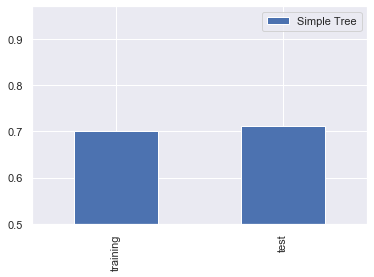

In [78]:
# Defining the model
tree = DecisionTreeClassifier(random_state=0, max_depth=4)

# Using the evaluate function to evaluate the model over our data
tree_train, tree_test =evaluate(baselinedataset, tree, verbose = True)

# Plotting the results of our first model
plot_compare(classification_results, 'Simple Tree', tree_train, tree_test)

We see that the tree with a depth of 4, is able to predict the different classes with an accuracy of 71%.

# Optimizing the depth of the tree

In [79]:
# Defining the baseline AGAIN
def baselinedataset():
    TrainV = Dataset('TrainValues.csv')
    TrainL = Dataset('TrainLabels.csv')
    TestV= Dataset('TestValues.csv')
    TrainWater = copy(TrainV).add_columns(TrainL.features["status_group"])
    TrainWater.set_target('status_group')
    TrainWater.drop_columns(["date_recorded", "funder", "installer", "wpt_name", "subvillage", "ward",
                             "scheme_name", "lga"])
    TrainWater.onehot_encode(TrainWater.names('categorical'))
    return TrainWater

In [80]:
OptimizedTree = baselinedataset()

In [14]:
# Here we iterate throught the different depths of the trees so we can optimize our previous model 
# to have a higher accuracy
min_depth = 4
max_depth = 30

metric_train = []
metric_test = []

for i in tqdm_notebook(range(min_depth, max_depth)):
    tree = DecisionTreeClassifier(random_state=0, max_depth=i) 
    tree_train, tree_test =evaluate(OptimizedTree, tree)
    metric_train.append(tree_train)
    metric_test.append(np.median(tree_test))

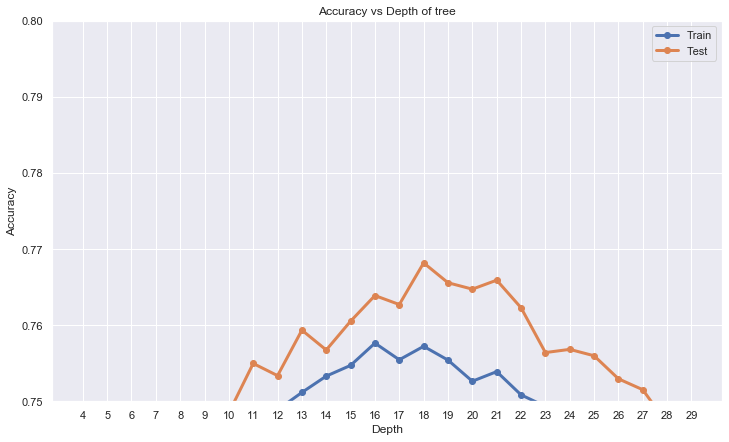

In [15]:
# Plotting the results of the different trees to choose the optimal depth
metrics = pd.DataFrame({'training': metric_train, 'testing': metric_test})

plt.figure(figsize=(12,7))
plt.plot(np.arange(4,30, 1), metrics, linewidth=3, linestyle='-', marker='o') 
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Depth of tree')
plt.ylim(0.75,0.8)
plt.xticks(np.arange(4, 30, 1))
plt.legend(('Train', 'Test'))
plt.show()

Avg accuracy: 0.757 +/-0.006
Accuracy on test: 0.768


<Figure size 648x504 with 0 Axes>

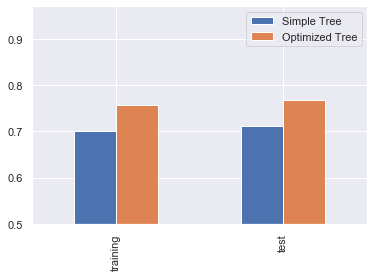

In [81]:
# Defining the model again but with the optimal depth of the tree that we found.
tree = DecisionTreeClassifier(random_state=0, max_depth=18)

# Using the evaluate function to evaluate the model over our data
tree_train, tree_test =evaluate(OptimizedTree, tree, verbose = True)

# Plotting the results of our new model
plot_compare(classification_results, 'Optimized Tree', tree_train, tree_test)

We can observed that from the optimization of the depth of our tree, our model gains a 5% accuracy with 76% in the test set.

# Feature Engineering

In [82]:
# Defining again the dataset we are going to use to do feature engineering
def fedataset():
    TrainV = Dataset('TrainValues.csv')
    TrainL = Dataset('TrainLabels.csv')
    TestV= Dataset('TestValues.csv')
    TrainWater = copy(TrainV).add_columns(TrainL.features["status_group"])
    TrainWater.set_target('status_group')
    TrainWater.drop_columns(["funder", "installer", "wpt_name", "subvillage", "ward","scheme_name", "lga"])
    TrainWater.to_categorical(["district_code","region_code"])
    return TrainWater

In [83]:
fedataset = fedataset()

## Extracting information from date columns

In [84]:
# Extracting the year and month from the variable "date_recorded"
fedataset.features["date_recorded"] = pd.to_datetime(fedataset.features["date_recorded"])
fedataset.features["year_recorded"] = fedataset.features["date_recorded"].apply(lambda x: x.year)
fedataset.features["month_recorded"] = fedataset.features["date_recorded"].apply(lambda x: x.month)

fedataset.to_categorical("month_recorded")
fedataset.to_categorical("year_recorded")

## Fixing errors in columns

In [203]:
# We can see we have errors in the following variables: latitude,longitud, gps_height and population
fedataset.features[fedataset.numerical_features].describe() 

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [85]:
# Fixing the error in the data: We bassically replace the missing the N/A and 0 with the mean of its corresponding district_code
# Idea adopted from <https://zlatankr.github.io/posts/2017/01/23/pump-it-up>
fedataset.features[fedataset.features["longitude"] == 0]['latitude'] = 0
longitudemean = fedataset.features[fedataset.features["longitude"] != 0].groupby(["district_code"])["longitude"].mean()
latitudemean = fedataset.features[fedataset.features["latitude"] != 0].groupby(["district_code"])["latitude"].mean()
heightmean = fedataset.features[fedataset.features["gps_height"] != 0].groupby(["district_code"])["gps_height"].mean()
populationmean = fedataset.features[fedataset.features["population"] != 0].groupby(["district_code"])["population"].mean()
constructionmean = fedataset.features[fedataset.features["construction_year"] != 0].groupby(["district_code"])["construction_year"].mean()
meantable = pd.concat([longitudemean,latitudemean,heightmean,populationmean,constructionmean], axis=1)
meantable.columns = ['meanlongitude','meanlatitude','meangps_height','meanpopulation','meanconstruction']

fedataset.features = pd.merge(fedataset.features, meantable, left_on=["district_code"], right_index=True, how='left')

fedataset.features['longitude'] = np.where(fedataset.features['longitude'] == 0, fedataset.features['meanlongitude'],fedataset.features['longitude'])
fedataset.features['longitude'] = fedataset.features['longitude'].fillna(fedataset.features['longitude'].mean())
fedataset.features['latitude'] = np.where(fedataset.features['latitude'] == 0, fedataset.features['meanlatitude'], fedataset.features['latitude'])
fedataset.features['latitude'] = fedataset.features['latitude'].fillna(fedataset.features['latitude'].mean())
fedataset.features['gps_height'] = np.where(fedataset.features['gps_height'] == 0, fedataset.features['meangps_height'],fedataset.features['gps_height'])
fedataset.features['gps_height'] = fedataset.features['gps_height'].fillna(fedataset.features['gps_height'].mean())
fedataset.features['population'] = np.where(fedataset.features['population'] == 0, fedataset.features['meanpopulation'],fedataset.features['population'])
fedataset.features['population'] = fedataset.features['population'].fillna(fedataset.features['population'].mean())
fedataset.features['construction_year'] = np.where(fedataset.features['construction_year'] == 0, fedataset.features['meanconstruction'],fedataset.features['construction_year'])
fedataset.features['construction_year'] = fedataset.features['construction_year'].fillna(fedataset.features['construction_year'].mean())

In [86]:
# Dropping the columns we create to fix the errors
fedataset.drop_columns(['meanlongitude', 'meanlatitude', 'meangps_height', 'meanpopulation','meanconstruction'])
fedataset.drop_columns(['meanlongitude', 'meanlatitude', 'meangps_height', 'meanpopulation','meanconstruction'])

In [195]:
# Checking if the errors were fixed
fedataset.features[fedataset.numerical_features].describe() 

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,meanlongitude,meanlatitude,meangps_height,meanpopulation,meanconstruction
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59365.000000,59365.000000,59296.000000
mean,37115.131768,317.650385,1041.244141,35.148765,-5.706033e+00,0.474141,15.297003,5.629747,281.124397,1996.836915,35.148765,-5.706033,1041.244141,281.124397,1996.836915
std,21453.128371,2997.574558,508.276414,2.567516,2.946019e+00,12.236230,17.587406,9.633649,453.164114,10.114394,1.026750,1.225147,253.057419,80.423695,1.606346
min,0.000000,0.000000,-90.000000,29.607122,-1.164944e+01,0.000000,1.000000,0.000000,1.000000,1960.000000,32.290148,-10.426976,-25.333333,105.500000,1993.025424
25%,18519.750000,0.000000,768.784663,33.354079,-8.540621e+00,0.000000,5.000000,2.000000,100.000000,1995.000000,34.766709,-6.370696,980.406531,247.971521,1995.696643
50%,37061.500000,0.000000,1106.000000,35.059489,-5.021597e+00,0.000000,12.000000,3.000000,247.971521,1997.540265,35.019680,-5.061056,1035.829251,259.051019,1996.616687
75%,55656.500000,20.000000,1357.935826,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,314.577914,2004.000000,35.236521,-4.898312,1154.388257,314.577914,1997.540265
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,39.740153,-2.856005,1472.082822,881.023762,2003.137931


## Filling N/A

In [87]:
# Filling N/A with False
fedataset.features["permit"].fillna(False)
fedataset.features["public_meeting"].fillna(False)

0         True
1        False
2         True
3         True
4         True
         ...  
59395     True
59396     True
59397     True
59398     True
59399     True
Name: public_meeting, Length: 59400, dtype: bool

In [88]:
fedataset.features[fedataset.nas()].isna().sum()

public_meeting       3334
scheme_management    3877
permit               3056
dtype: int64

## Dropping unnecessary columns

Looking at the variables we decide to drop the following variables either because they were highly correlated to other variables, had blanks or nulls or simply they weren't useful to predict (id)

In [89]:
# Dropping useless columns because
fedataset.drop_columns(['id','amount_tsh',  'num_private', 'region', 'quantity',\
                      'quality_group', 'source_type', 'payment','waterpoint_type_group',\
                      'extraction_type_group'])

## Creating new columns

In [126]:
# Creating a function to create a variable "operation time" of the water pump
def operationtime(data):
    newcolumns = pd.DataFrame(columns = None)
    data.to_numerical("year_recorded")
    newcolumns["operation_time"] = data.features["year_recorded"] - data.features["construction_year"]
    data.add_columns(newcolumns)
    data.to_categorical("year_recorded")
    return data

In [91]:
fedataset = operationtime(fedataset)

In [92]:
# Perfoming onehot encoding in our final dataset after the feature engineering
fedataset.onehot_encode(fedataset.names('categorical'))

Avg accuracy: 0.772 +/-0.006
Accuracy on test: 0.781


<Figure size 648x504 with 0 Axes>

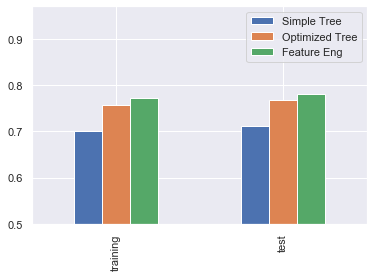

In [93]:
# We use the same model with the optimal depth of the tree that we found before.
tree = DecisionTreeClassifier(random_state=0, max_depth=18)

# Using the evaluate function to evaluate the model over our data
tree_train, tree_test =evaluate(fedataset, tree, verbose = True)

# Plotting the results of our new model
plot_compare(classification_results, 'Feature Eng', tree_train, tree_test)

Doing Feature Engineering help our model to perform better and now the model predict with an accuracy of 78,1% in the test set.

# Optimizing the depth of the tree for the new data

In [127]:
# Defining a function to replace the N/A and 0 from the columns we previously fix errors
def meandc(data):
    data.features[data.features["longitude"] == 0]['latitude'] = 0
    transform = ["longitude","latitude","gps_height","population","construction_year"]
    for i in transform:
        meanvalue = data.features[data.features[i] != 0].groupby(["district_code"])[i].mean().rename("mean")
        data.features = pd.merge(data.features, meanvalue, left_on=["district_code"], right_index=True, how='left')
        data.features
        data.features[i] = np.where(data.features[i] == 0, data.features['mean'],data.features[i])
        data.features[i] = data.features[i].fillna(data.features[i].mean())
        del data.features["mean"]
    return data

In [13]:
# Defining the final dataset with the feature eng perfomed because was the dataset with worked better for our model
def finalfedataset():
    TrainV = Dataset('TrainValues.csv')
    TrainL = Dataset('TrainLabels.csv')
    TestV= Dataset('TestValues.csv')
    TrainWater = copy(TrainV).add_columns(TrainL.features["status_group"])
    TrainWater.set_target('status_group')
    TrainWater.drop_columns(["funder", "installer", "wpt_name", "subvillage", "ward","scheme_name", "lga"])
    TrainWater.to_categorical(["district_code","region_code"])
    TrainWater.features["date_recorded"] = pd.to_datetime(TrainWater.features["date_recorded"])
    TrainWater.features["year_recorded"] = TrainWater.features["date_recorded"].apply(lambda x: x.year)
    TrainWater.features["month_recorded"] = TrainWater.features["date_recorded"].apply(lambda x: x.month)
    TrainWater.to_categorical("month_recorded")
    TrainWater.to_categorical("year_recorded")
    TrainWater = meandc(TrainWater)
    TrainWater.drop_columns(['id','amount_tsh',  'num_private', 'region', 'quantity',\
                      'quality_group', 'source_type', 'payment','waterpoint_type_group',\
                      'extraction_type_group'])
    TrainWater.features["permit"] = TrainWater.features["permit"].fillna(False)
    TrainWater.features["public_meeting"] = TrainWater.features["public_meeting"].fillna(False)
    TrainWater = operationtime(TrainWater)
    TrainWater.onehot_encode(TrainWater.names('categorical'))
    return TrainWater

In [96]:
OptimizedTreeFE = finalfedataset()

In [370]:
# Here we iterate throught the different depths of the trees so we can optimize our previous model to have a higher accuracy
min_depth = 4
max_depth = 30

metric_train = []
metric_test = []

for i in tqdm_notebook(range(min_depth, max_depth)):
    tree = DecisionTreeClassifier(random_state=0, max_depth=i) 
    tree_train, tree_test =evaluate(OptimizedTreeFE, tree)
    metric_train.append(tree_train)
    metric_test.append(np.median(tree_test))

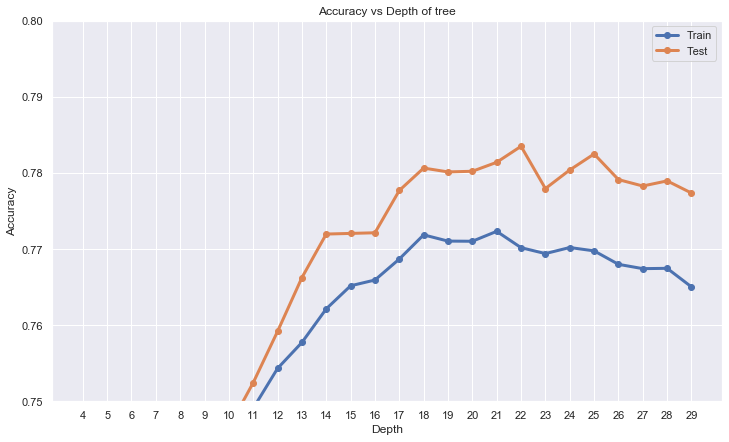

In [371]:
# Plotting the results of the different trees to choose the optimal depth
metrics = pd.DataFrame({'training': metric_train, 'testing': metric_test})

plt.figure(figsize=(12,7))
plt.plot(np.arange(4,30, 1), metrics, linewidth=3, linestyle='-', marker='o') 
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Depth of tree')
plt.ylim(0.75,0.8)
plt.xticks(np.arange(4, 30, 1))
plt.legend(('Train', 'Test'))
plt.show()

Avg accuracy: 0.770 +/-0.004
Accuracy on test: 0.784


<Figure size 648x504 with 0 Axes>

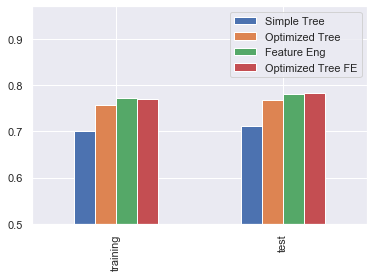

In [97]:
# Defining the model again but with the optimal depth of the tree that we found for the new data.
tree = DecisionTreeClassifier(random_state=0, max_depth=22)

# Using the evaluate function to evaluate the model over our data
tree_train, tree_test =evaluate(OptimizedTreeFE, tree, verbose = True)

# Plotting the results of our new model
plot_compare(classification_results, 'Optimized Tree FE', tree_train, tree_test)

By adjusting the depth of the tree after doing Feature Eng we did a very small improvement in the predicting accuracy of our model.

# Dropping N/A

In [104]:
# Defining the dataset with the feature eng perfomed
def nadataset():
    TrainV = Dataset('TrainValues.csv')
    TrainL = Dataset('TrainLabels.csv')
    TestV= Dataset('TestValues.csv')
    TrainWater = copy(TrainV).add_columns(TrainL.features["status_group"])
    TrainWater.set_target('status_group')
    TrainWater.drop_columns(["funder", "installer", "wpt_name", "subvillage", "ward","scheme_name", "lga"])
    TrainWater.to_categorical(["district_code","region_code"])
    TrainWater.features["date_recorded"] = pd.to_datetime(TrainWater.features["date_recorded"])
    TrainWater.features["year_recorded"] = TrainWater.features["date_recorded"].apply(lambda x: x.year)
    TrainWater.features["month_recorded"] = TrainWater.features["date_recorded"].apply(lambda x: x.month)
    TrainWater.to_categorical("month_recorded")
    TrainWater.to_categorical("year_recorded")
    TrainWater = meandc(TrainWater)
    TrainWater.drop_columns(['id','amount_tsh',  'num_private', 'region', 'quantity',\
                      'quality_group', 'source_type', 'payment','waterpoint_type_group',\
                      'extraction_type_group'])
    TrainWater.features["permit"] = TrainWater.features["permit"].fillna(False)
    TrainWater.features["public_meeting"] = TrainWater.features["public_meeting"].fillna(False)
    TrainWater = operationtime(TrainWater)
    return TrainWater

In [105]:
nadataset = nadataset()

In [108]:
# Checking for N/A
nadataset.features[nadataset.nas()].isna().sum()

scheme_management    3877
dtype: int64

In [109]:
# Dropping N/A
nadataset.drop_na()
nadataset.nas()

[]

In [110]:
# Onehot encoding
nadataset.onehot_encode(nadataset.names('categorical'))

Avg accuracy: 0.772 +/-0.009
Accuracy on test: 0.788


<Figure size 648x504 with 0 Axes>

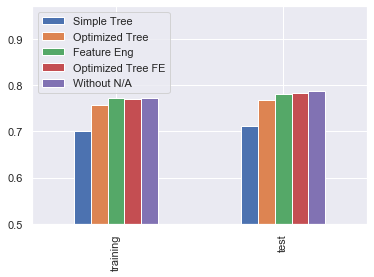

In [111]:
# Defining the model again but with the optimal depth of the tree that we found for the new data.
tree = DecisionTreeClassifier(random_state=0, max_depth=22)

# Using the evaluate function to evaluate the model over our data
tree_train, tree_test =evaluate(nadataset, tree, verbose = True)

# Plotting the results of our new model
plot_compare(classification_results, 'Without N/A', tree_train, tree_test)

Dropping N/A also improves a little bit the accuracy of our model

# Dropping outliers

In [112]:
# Defining the AGAIN the dataset without N/A
def withoutoutliersdataset():
    TrainV = Dataset('TrainValues.csv')
    TrainL = Dataset('TrainLabels.csv')
    TestV= Dataset('TestValues.csv')
    TrainWater = copy(TrainV).add_columns(TrainL.features["status_group"])
    TrainWater.set_target('status_group')
    TrainWater.drop_columns(["funder", "installer", "wpt_name", "subvillage", "ward","scheme_name", "lga"])
    TrainWater.to_categorical(["district_code","region_code"])
    TrainWater.features["date_recorded"] = pd.to_datetime(TrainWater.features["date_recorded"])
    TrainWater.features["year_recorded"] = TrainWater.features["date_recorded"].apply(lambda x: x.year)
    TrainWater.features["month_recorded"] = TrainWater.features["date_recorded"].apply(lambda x: x.month)
    TrainWater.to_categorical("month_recorded")
    TrainWater.to_categorical("year_recorded")
    TrainWater = meandc(TrainWater)
    TrainWater.drop_columns(['id','amount_tsh',  'num_private', 'region', 'quantity',\
                      'quality_group', 'source_type', 'payment','waterpoint_type_group',\
                      'extraction_type_group'])
    TrainWater.features["permit"] = TrainWater.features["permit"].fillna(False)
    TrainWater.features["public_meeting"] = TrainWater.features["public_meeting"].fillna(False)
    TrainWater = operationtime(TrainWater)
    TrainWater.drop_na()
    return TrainWater

In [113]:
withoutoutliersdataset = withoutoutliersdataset()

In [114]:
# Checking outliers
withoutoutliersdataset.outliers()

array([   16,    45,    87, ..., 55428, 55475, 55520], dtype=int64)

In [115]:
# Dropping outliers
withoutoutliersdataset.drop_samples(withoutoutliersdataset.outliers())

In [116]:
# Onehot encoding
withoutoutliersdataset.onehot_encode(withoutoutliersdataset.names('categorical'))

Avg accuracy: 0.777 +/-0.007
Accuracy on test: 0.779


<Figure size 648x504 with 0 Axes>

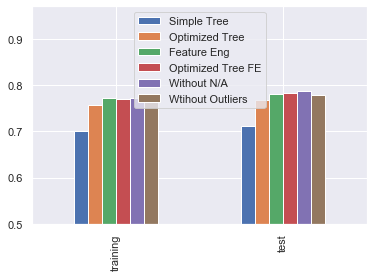

In [117]:
# Defining the model again but with the optimal depth of the tree that we found.
tree = DecisionTreeClassifier(random_state=0, max_depth=22)

# Using the evaluate function to evaluate the model over our data
tree_train, tree_test =evaluate(withoutoutliersdataset, tree, verbose = True)

# Plotting the results of our new model
plot_compare(classification_results, 'Wtihout Outliers', tree_train, tree_test)

Taking out the Outliers from our dataset did not improve the accuracy of our model and makes it less accurate. So we continue to work with the date after taking N/A

# Gradient Boosting Model

In [17]:
# Defining the AGAIN the dataset without N/A
def finalnadataset():
    TrainV = Dataset('TrainValues.csv')
    TrainL = Dataset('TrainLabels.csv')
    TestV= Dataset('TestValues.csv')
    TrainWater = copy(TrainV).add_columns(TrainL.features["status_group"])
    TrainWater.set_target('status_group')
    TrainWater.drop_columns(["funder", "installer", "wpt_name", "subvillage", "ward","scheme_name", "lga"])
    TrainWater.to_categorical(["district_code","region_code"])
    TrainWater.features["date_recorded"] = pd.to_datetime(TrainWater.features["date_recorded"])
    TrainWater.features["year_recorded"] = TrainWater.features["date_recorded"].apply(lambda x: x.year)
    TrainWater.features["month_recorded"] = TrainWater.features["date_recorded"].apply(lambda x: x.month)
    TrainWater.to_categorical("month_recorded")
    TrainWater.to_categorical("year_recorded")
    TrainWater = meandc(TrainWater)
    TrainWater.drop_columns(['id','amount_tsh',  'num_private', 'region', 'quantity',\
                      'quality_group', 'source_type', 'payment','waterpoint_type_group',\
                      'extraction_type_group'])
    TrainWater.features["permit"] = TrainWater.features["permit"].fillna(False)
    TrainWater.features["public_meeting"] = TrainWater.features["public_meeting"].fillna(False)
    TrainWater = operationtime(TrainWater)
    TrainWater.drop_na()
    TrainWater.onehot_encode(TrainWater.names('categorical'))
    return TrainWater

In [119]:
gbdataset = finalnadataset()

Avg accuracy: 0.770 +/-0.005
Accuracy on test: 0.782


<Figure size 648x504 with 0 Axes>

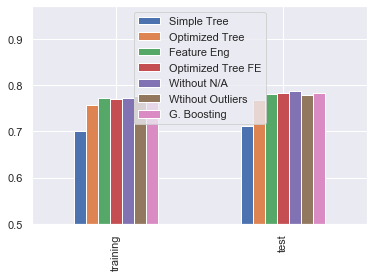

In [120]:
# Because dropping N/A and outliers didn't improve the accuracy of our model we are using the baseline dataset 
# we defined before
gb = GradientBoostingClassifier(n_estimators=100, 
                                learning_rate=1.0,
                                max_features=10,
                                max_depth=4, 
                                random_state=0)

#Using the evaluate function to evaluate the model over our data
gb_train, gb_test = evaluate(gbdataset, gb, verbose = True)

#Plotting the results of our new model
plot_compare(classification_results, 'G. Boosting', gb_train, gb_test)

Surprisingly with Gradient Boosting our model low its performance and predict with less accuracy.

# Optimizing Gradient Boosting Depth

In [416]:
# The same as with trees, we iterate throught the different depths of the G. Boosting to see if 
# we can optimize our previous model 

min_depth = 1
max_depth = 20
metric_train = []
metric_test = []
for i in tqdm_notebook(range(min_depth, max_depth)):
    gb = GradientBoostingClassifier(n_estimators=100, 
                                learning_rate=1.0,
                                max_features=10,
                                max_depth=i, 
                                random_state=0)

    gb_train, gb_test =evaluate(gbdataset, gb, verbose = True)
    metric_train.append(gb_train)
    metric_test.append(np.median(gb_test))

Avg accuracy: 0.742 +/-0.007
Accuracy on test: 0.754
Avg accuracy: 0.751 +/-0.007
Accuracy on test: 0.762
Avg accuracy: 0.762 +/-0.008
Accuracy on test: 0.773
Avg accuracy: 0.770 +/-0.005
Accuracy on test: 0.782
Avg accuracy: 0.772 +/-0.006
Accuracy on test: 0.786
Avg accuracy: 0.777 +/-0.007
Accuracy on test: 0.794
Avg accuracy: 0.779 +/-0.007
Accuracy on test: 0.790
Avg accuracy: 0.779 +/-0.008
Accuracy on test: 0.787
Avg accuracy: 0.777 +/-0.010
Accuracy on test: 0.787
Avg accuracy: 0.773 +/-0.006
Accuracy on test: 0.785
Avg accuracy: 0.761 +/-0.020
Accuracy on test: 0.755
Avg accuracy: 0.738 +/-0.012
Accuracy on test: 0.749
Avg accuracy: 0.672 +/-0.040
Accuracy on test: 0.677
Avg accuracy: 0.577 +/-0.048
Accuracy on test: 0.558
Avg accuracy: 0.527 +/-0.036
Accuracy on test: 0.562
Avg accuracy: 0.526 +/-0.031
Accuracy on test: 0.501
Avg accuracy: 0.504 +/-0.019
Accuracy on test: 0.555
Avg accuracy: 0.528 +/-0.015
Accuracy on test: 0.488
Avg accuracy: 0.524 +/-0.023
Accuracy on test:

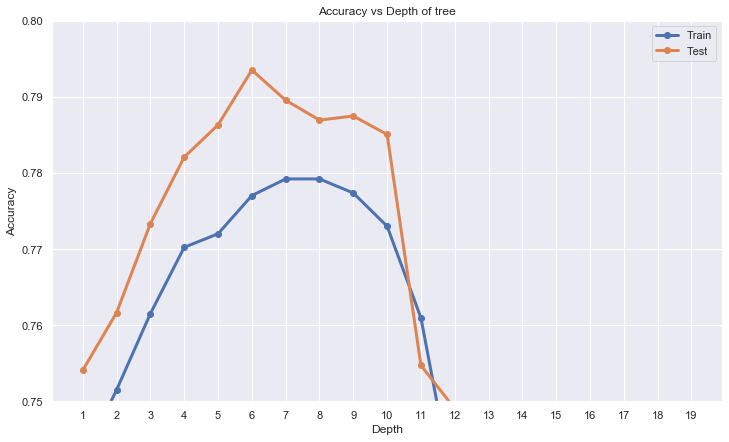

In [417]:
# Plotting the results of the different G. Boosting models to choose the optimal depth
metrics = pd.DataFrame({'training': metric_train, 'testing': metric_test})

plt.figure(figsize=(12,7))
plt.plot(np.arange(1,20, 1), metrics, linewidth=3, linestyle='-', marker='o') 
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Depth of tree')
plt.ylim(0.75,0.8)
plt.xticks(np.arange(1, 20, 1))
plt.legend(('Train', 'Test'))
plt.show()

Avg accuracy: 0.777 +/-0.007
Accuracy on test: 0.794


<Figure size 648x504 with 0 Axes>

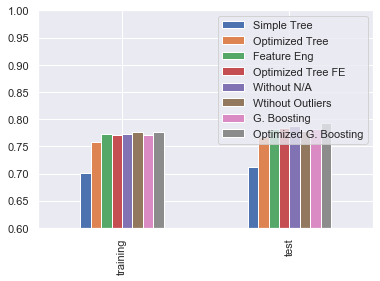

In [121]:
# Defining the model again but with the optimal depth of the G. Boosting model that we found.
gb = GradientBoostingClassifier(n_estimators=100, 
                                learning_rate=1.0,
                                max_features=10,
                                max_depth=6, 
                                random_state=0)

# Using the evaluate function to evaluate the model over our data
gb_train, gb_test =evaluate(gbdataset, gb, verbose = True)

# Plotting the results of our new model
plot_compare(classification_results, 'Optimized G. Boosting', gb_train, gb_test, ymin=0.60, ymax=1)

With the optimized Gradient Boosting this pass to be our best model with a 79,4% accuracy.

# Random Forest

In [122]:
rfdataset = finalnadataset()

Avg accuracy: 0.804 +/-0.005
Accuracy on test: 0.808


<Figure size 648x504 with 0 Axes>

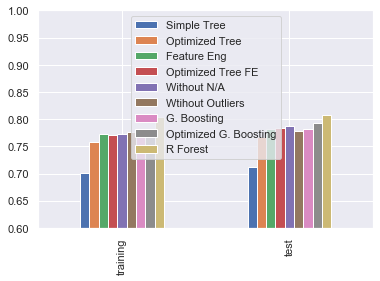

In [123]:
# Defining the model again but this time using Random Forest
rf = RandomForestClassifier(criterion= 'gini',
                                n_estimators=500, 
                                max_features='auto',
                                oob_score = True, 
                                random_state=1,
                                n_jobs = -1)

# Using the evaluate function to evaluate the model over our data
rf_train, rf_test =evaluate(rfdataset, rf, verbose = True)

# Plotting the results of our new model
plot_compare(classification_results, 'R Forest', rf_train, rf_test, ymin=0.60, ymax=1)

Perfoming Random Forest gives the best score so far with 80,8% accuracy.

# Optimizing the hyperparameters of Random Forest 
The idea here is to optimize the performance of the model by adjusting the hyperparameters of the model

In [49]:
# Defining parameters
parameters = {"min_samples_split": [3, 5, 7],
              "min_samples_leaf": [3, 5, 7],
             "n_estimators" : [400, 500, 700],
             }

In [52]:
# Finding the best hyperparameters for our data
rf = RandomForestClassifier(criterion= 'gini',
                                n_estimators=500, 
                                max_features='auto',
                                oob_score = True, 
                                random_state=1,
                                n_jobs = -1)

X, Y = rfdataset.split()
grid_rf = GridSearchCV(rf, parameters, cv=10, n_jobs=-1)
grid_rf.fit(X.train, Y.train)
score = grid_rf.score(X.train, Y.train)
best_params = grid_rf.best_params_

print('Score: {:.4f}'.format(score))
print('Best Params:\n{}'.format(best_params))

Score: 0.8473
Best Params:
{'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 700}


Avg accuracy: 0.802 +/-0.008
Accuracy on test: 0.811


<Figure size 648x504 with 0 Axes>

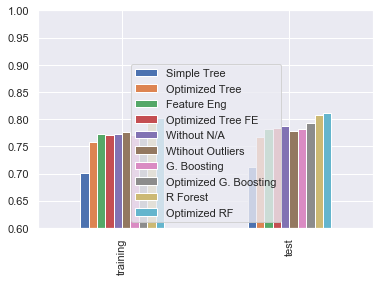

In [127]:
# Defining the model again but adjusting the parameters to the optimal ones
rf = RandomForestClassifier(criterion= 'gini',
                                n_estimators=700,
                                min_samples_leaf= 3,
                                min_samples_split = 3,
                                max_features='auto',
                                oob_score = True, 
                                random_state=1,
                                n_jobs = -1)

# Using the evaluate function to evaluate the model over our data
rf_train, rf_test =evaluate(rfdataset, rf, verbose = True)

# Plotting the results of our new model
plot_compare(classification_results, 'Optimized RF', rf_train, rf_test, ymin=0.60, ymax=1)

After tuning the hyperparameters we get the best result so far, our model predict with 81.1% accuracy! We try to optimize other parameters but it was to computational expensive and our computers run out of capacity in the process, however I'm sure the model could still be improved through this method.

# Principal Component Analysis (PCA)

In [128]:
# Defining a new evaluate function for the PCA, so the PCA is not perfomed over the entire dataset and we avoid BIAS
scores = []

def evaluatePCA(X_train,y_train,X_test,y_test, estimator, store=True, verbose=False):
    
    estimator.fit(X_train, y_train)
    accs = cross_val_score(estimator, X_train, y_train, cv=10)
    if verbose is True:
        print('Avg accuracy: {:.3f} +/-{:.3f}'.format(
            np.mean(accs), np.std(accs)))
    train_score = np.mean(accs)
    y_pred = estimator.predict(X_test)
    test_score = estimator.score(X_test, y_test)
    if verbose is True:
        print('Accuracy on test: {:.3f}'.format(test_score))
    if store is True:
        scores.append(test_score)
    return train_score, test_score

In [129]:
# Defining the dataset for PCA
def PCAdataset():
    TrainV = Dataset('TrainValues.csv')
    TrainL = Dataset('TrainLabels.csv')
    TestV= Dataset('TestValues.csv')
    TrainWater = copy(TrainV).add_columns(TrainL.features["status_group"])
    TrainWater.set_target('status_group')
    TrainWater.drop_columns(["funder", "installer", "wpt_name", "subvillage", "ward","scheme_name", "lga"])
    TrainWater.to_categorical(["district_code","region_code"])
    TrainWater.features["date_recorded"] = pd.to_datetime(TrainWater.features["date_recorded"])
    TrainWater.features["year_recorded"] = TrainWater.features["date_recorded"].apply(lambda x: x.year)
    TrainWater.features["month_recorded"] = TrainWater.features["date_recorded"].apply(lambda x: x.month)
    TrainWater.to_categorical("month_recorded")
    TrainWater.to_categorical("year_recorded")
    TrainWater = meandc(TrainWater)
    TrainWater.drop_columns(['id','amount_tsh',  'num_private', 'region', 'quantity',\
                      'quality_group', 'source_type', 'payment','waterpoint_type_group',\
                      'extraction_type_group'])
    TrainWater.features["permit"] = TrainWater.features["permit"].fillna(False)
    TrainWater.features["public_meeting"] = TrainWater.features["public_meeting"].fillna(False)
    TrainWater = operationtime(TrainWater)
    TrainWater.drop_na()
    TrainWater.scale()
    TrainWater.onehot_encode(TrainWater.names('categorical'))
    return TrainWater

In [130]:
pcadataset = PCAdataset()

In [131]:
# SPliting fot the PCA analysis
X, y = pcadataset.split()

# Setting th PCA to capture .95 of the variance
pca = PCA(.95)

# Creating the pca function
PrincipalComponents = pca.fit_transform(X.train)

In [132]:
# Tranforming the data so we can perfom PCA
X_trainPCA = pca.transform(X.train)
X_testPCA = pca.transform(X.test)

In [133]:
# Checking the number of PCA that were created
pcadataframe = pd.DataFrame(data = PrincipalComponents)
pcadataframe

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
0,-1.837217,-0.958940,-1.342054,0.202731,-0.620662,-0.094181,0.869210,-0.048910,0.297893,0.169301,...,-0.058013,-0.020347,-0.030829,-0.022323,0.079077,0.048612,0.038844,0.032550,-0.110101,-0.002567
1,-0.529254,-3.078053,0.504737,-0.154235,-0.146276,0.244018,-1.121261,-1.159412,0.671559,0.413271,...,-0.036468,-0.009363,-0.011948,0.041326,-0.017803,-0.062851,0.146124,0.033708,0.003243,-0.032266
2,-0.568801,1.551403,0.916797,0.215383,-0.915498,-0.078496,0.872011,-0.180982,0.425277,0.697580,...,0.016655,-0.021985,0.023748,-0.006696,-0.025330,-0.006044,-0.000337,0.000828,0.014947,-0.004308
3,-1.556569,0.032616,-2.386302,0.968230,-0.626875,0.609677,0.240358,0.233783,0.585486,0.456040,...,-0.025925,0.009757,0.029736,0.016082,0.012923,-0.008168,0.014684,0.003181,0.014113,0.012316
4,2.735243,-1.321513,0.863755,0.037570,0.050113,0.173015,0.998153,-0.151351,0.055997,1.082031,...,-0.041219,-0.064800,0.047617,-0.038996,0.014146,-0.033891,0.020399,0.004201,0.053577,-0.013515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44413,-2.059064,1.182909,0.469431,-1.389847,0.469311,0.247117,-0.531024,-0.106439,-0.370293,0.663382,...,0.026309,0.001592,-0.048525,-0.040851,0.014442,0.000967,0.018509,0.001196,0.032720,-0.020018
44414,-0.145507,-0.916385,0.269693,0.120149,0.030570,-0.142056,0.692803,-0.393837,0.231069,1.656784,...,0.037738,0.113733,-0.008914,0.012865,-0.057148,0.022796,-0.083480,-0.084151,-0.003670,0.048334
44415,1.847160,1.132324,0.902768,0.047896,0.414078,-1.947778,-1.434430,-1.029266,-0.157942,-0.016879,...,0.010375,0.004376,-0.047712,-0.005874,-0.110526,0.059748,-0.105565,-0.003588,0.063501,0.065969
44416,-0.131322,0.760906,1.143997,0.263468,-0.321318,0.128567,-0.502013,-0.982033,0.858909,0.197986,...,0.018548,0.010384,-0.025710,-0.029587,-0.041283,0.067124,-0.083376,-0.007198,-0.007643,-0.028436


Avg accuracy: 0.801 +/-0.006
Accuracy on test: 0.807


<Figure size 648x504 with 0 Axes>

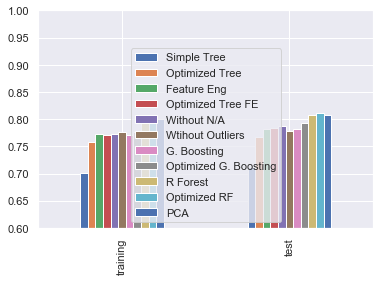

In [135]:
# Defining the model again, we are going to use the optimal depth we found for the original data eventhough we are working only
# with the created PCA. Later we will optimized the model
rf = RandomForestClassifier(criterion= 'gini',
                                n_estimators=700,
                                min_samples_leaf= 3,
                                min_samples_split = 3,
                                max_features='auto',
                                oob_score = True, 
                                random_state=1,
                                n_jobs = -1)

# Using the evaluate function to evaluate the model over our data
rf_train, rf_test =evaluatePCA(X_trainPCA, y.train, X_testPCA, y.test, rf, verbose = True)

# Plotting the results of our new model
plot_compare(classification_results, 'PCA', rf_train, rf_test, ymin=0.60, ymax=1)

Performing PCA did not improve the accuracy of our model, nevertheless we continue to optimize the depth of the model to see if PCA perform better

# Optimizing PCA depth

In [136]:
# The same as with trees and G.Boost, we iterate throught the different depth to see how our model perform.
min_depth = 1
max_depth = 18
metric_train = []
metric_test = []
for i in tqdm_notebook(range(min_depth, max_depth)):
    rf = RandomForestClassifier(criterion= 'gini',
                                n_estimators=700,
                                min_samples_leaf= 3,
                                max_depth=i,
                                min_samples_split = 3,
                                max_features='auto',
                                oob_score = True, 
                                random_state=1,
                                n_jobs = -1)
                                
    rf_train, rf_test =evaluatePCA(X_trainPCA, y.train, X_testPCA, y.test, rf, verbose = True)
    metric_train.append(rf_train)
    metric_test.append(np.median(rf_test))

Avg accuracy: 0.550 +/-0.001
Accuracy on test: 0.555
Avg accuracy: 0.610 +/-0.003
Accuracy on test: 0.617
Avg accuracy: 0.647 +/-0.006
Accuracy on test: 0.657
Avg accuracy: 0.678 +/-0.007
Accuracy on test: 0.686
Avg accuracy: 0.702 +/-0.006
Accuracy on test: 0.713
Avg accuracy: 0.719 +/-0.006
Accuracy on test: 0.729
Avg accuracy: 0.736 +/-0.007
Accuracy on test: 0.747
Avg accuracy: 0.751 +/-0.007
Accuracy on test: 0.762
Avg accuracy: 0.761 +/-0.007
Accuracy on test: 0.773
Avg accuracy: 0.772 +/-0.007
Accuracy on test: 0.784
Avg accuracy: 0.782 +/-0.007
Accuracy on test: 0.794
Avg accuracy: 0.788 +/-0.008
Accuracy on test: 0.799
Avg accuracy: 0.793 +/-0.008
Accuracy on test: 0.804
Avg accuracy: 0.796 +/-0.008
Accuracy on test: 0.806
Avg accuracy: 0.799 +/-0.007
Accuracy on test: 0.807
Avg accuracy: 0.801 +/-0.008
Accuracy on test: 0.808
Avg accuracy: 0.801 +/-0.008
Accuracy on test: 0.808



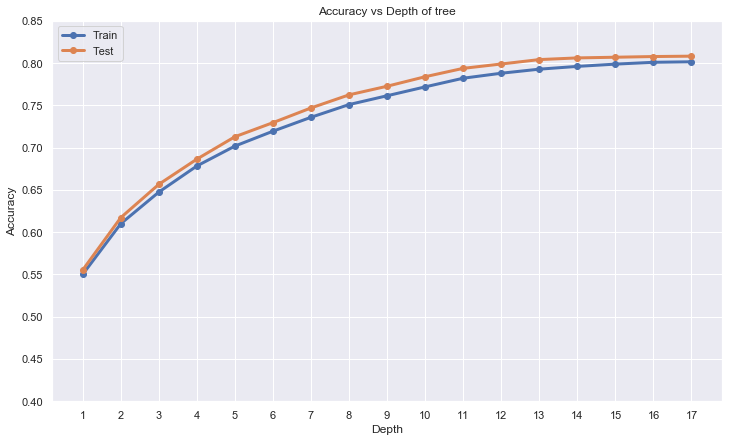

In [137]:
# Plotting the results of the different PCA models to choose the optimal depth
metrics = pd.DataFrame({'training': metric_train, 'testing': metric_test})

plt.figure(figsize=(12,7))
plt.plot(np.arange(1,18, 1), metrics, linewidth=3, linestyle='-', marker='o') 
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Depth of tree')
plt.ylim(0.4,.85)
plt.xticks(np.arange(1, 18, 1))
plt.legend(('Train', 'Test'))
plt.show()

Avg accuracy: 0.801 +/-0.008
Accuracy on test: 0.808


<Figure size 648x504 with 0 Axes>

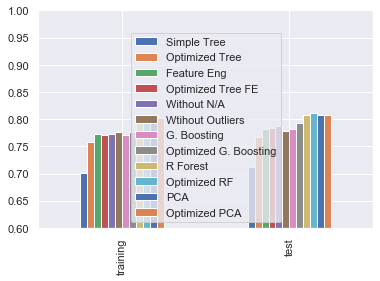

In [138]:
# Defining the model again but with the optimal depth of the PCA model that we found.
rf = RandomForestClassifier(criterion= 'gini',
                                n_estimators=700,
                                min_samples_leaf= 3,
                                min_samples_split = 3,
                                max_features='auto',
                                max_depth=17,
                                oob_score = True, 
                                random_state=1,
                                n_jobs = -1)

# Using the evaluate function to evaluate the model over our data
rf_train, rf_test =evaluatePCA(X_trainPCA, y.train, X_testPCA, y.test, rf, verbose = True)

# Plotting the results of our new model
plot_compare(classification_results, 'Optimized PCA', rf_train, rf_test, ymin=0.60, ymax=1)

Avg accuracy: 0.803 +/-0.007
Accuracy on test: 0.808


<Figure size 648x504 with 0 Axes>

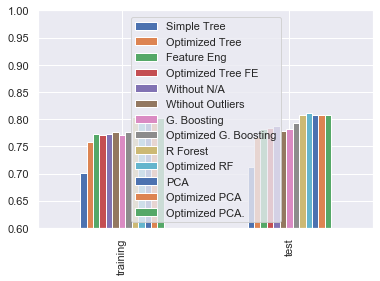

In [139]:
# Defining the model again but with the optimal depth of the PCA model that we found.
rf = RandomForestClassifier(criterion= 'gini',
                                n_estimators=700,
                                min_samples_leaf= 3,
                                min_samples_split = 3,
                                max_features='auto',
                                max_depth=18,
                                oob_score = True, 
                                random_state=1,
                                n_jobs = -1)

# Using the evaluate function to evaluate the model over our data
rf_train, rf_test =evaluatePCA(X_trainPCA, y.train, X_testPCA, y.test, rf, verbose = True)

# Plotting the results of our new model
plot_compare(classification_results, 'Optimized PCA.', rf_train, rf_test, ymin=0.60, ymax=1)

Even though we adjust the depth to the more optimal one, the model with PCA performed the same

# XGBoost

In [118]:
# Bringing the function to transform the data
def finalnadataset():
    TrainV = Dataset('TrainValues.csv')
    TrainL = Dataset('TrainLabels.csv')
    TestV= Dataset('TestValues.csv')
    TrainWater = copy(TrainV).add_columns(TrainL.features["status_group"])
    TrainWater.set_target('status_group')
    TrainWater.drop_columns(["funder", "installer", "wpt_name", "subvillage", "ward","scheme_name", "lga"])
    TrainWater.to_categorical(["district_code","region_code"])
    TrainWater.features["date_recorded"] = pd.to_datetime(TrainWater.features["date_recorded"])
    TrainWater.features["year_recorded"] = TrainWater.features["date_recorded"].apply(lambda x: x.year)
    TrainWater.features["month_recorded"] = TrainWater.features["date_recorded"].apply(lambda x: x.month)
    TrainWater.to_categorical("month_recorded")
    TrainWater.to_categorical("year_recorded")
    TrainWater = meandc(TrainWater)
    TrainWater.drop_columns(['id','amount_tsh',  'num_private', 'region', 'quantity',\
                      'quality_group', 'source_type', 'payment','waterpoint_type_group',\
                      'extraction_type_group'])
    TrainWater.features["permit"] = TrainWater.features["permit"].fillna(False)
    TrainWater.features["public_meeting"] = TrainWater.features["public_meeting"].fillna(False)
    TrainWater = operationtime(TrainWater)
    TrainWater.drop_na()
    TrainWater.onehot_encode(TrainWater.names('categorical'))
    return TrainWater

In [119]:
xgboostdata = finalnadataset()

Avg accuracy: 0.806 +/-0.006
Accuracy on test: 0.812
                         precision    recall  f1-score   support

             functional       0.82      0.88      0.85      6123
functional needs repair       0.52      0.38      0.44       759
         non functional       0.83      0.80      0.81      4223

               accuracy                           0.81     11105
              macro avg       0.72      0.69      0.70     11105
           weighted avg       0.81      0.81      0.81     11105

[[5368  202  553]
 [ 355  292  112]
 [ 792   72 3359]]


<Figure size 648x504 with 0 Axes>

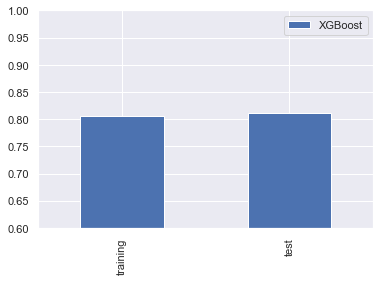

In [120]:
# Defining the model again but this time using XGBoost
xgb = xgb.XGBClassifier(learning_rate=0.1,n_estimators=100,
                                random_state=0,
                                max_depth=20,
                                n_jobs=-1)


# Using the evaluate function to evaluate the model over our data
xgb_train, xgb_test =evaluate(xgboostdata, xgb, verbose = True)

# Plotting the results of our new model
plot_compare(classification_results, 'XGBoost', xgb_train, xgb_test, ymin=0.60, ymax=1)

Finally we decide to try with xgboost classifier to deal again with the high dimensionality of our data. As expected is better predicting than any other model therefore we decide to use this final model to predict. As it can be observed from the results, this model has higher accuracy when predicting non functional water pumps that the ones that need repair.

# Final Prediction

In [128]:
# Defining the final transformations for our training 
def finalnadataset():
    TrainV = Dataset('TrainValues.csv')
    TrainL = Dataset('TrainLabels.csv')
    TestV= Dataset('TestValues.csv')
    TrainWater = copy(TrainV).add_columns(TrainL.features["status_group"])
    TrainWater.set_target('status_group')
    TrainWater.drop_columns(["funder", "installer", "wpt_name", "subvillage", "ward","scheme_name", "lga"])
    TrainWater.to_categorical(["district_code","region_code"])
    TrainWater.features["date_recorded"] = pd.to_datetime(TrainWater.features["date_recorded"])
    TrainWater.features["year_recorded"] = TrainWater.features["date_recorded"].apply(lambda x: x.year)
    TrainWater.features["month_recorded"] = TrainWater.features["date_recorded"].apply(lambda x: x.month)
    TrainWater.to_categorical("month_recorded")
    TrainWater.to_categorical("year_recorded")
    TrainWater = meandc(TrainWater)
    TrainWater.drop_columns(['id','amount_tsh',  'num_private', 'region', 'quantity',\
                      'quality_group', 'source_type', 'payment','waterpoint_type_group',\
                      'extraction_type_group'])
    TrainWater.features["permit"] = TrainWater.features["permit"].fillna(False)
    TrainWater.features["public_meeting"] = TrainWater.features["public_meeting"].fillna(False)
    TrainWater = operationtime(TrainWater)
    TrainWater.drop_na()
    return TrainWater

In [129]:
# Defining the final transformations for our test 
def testdataset(data):
    data = copy(data)
    data = data.drop_columns(["funder", "installer", "wpt_name", "subvillage", "ward","scheme_name", "lga"])
    data.to_categorical(["district_code","region_code"])
    data.features["date_recorded"] = pd.to_datetime(data.features["date_recorded"])
    data.features["year_recorded"] = data.features["date_recorded"].apply(lambda x: x.year)
    data.features["month_recorded"] = data.features["date_recorded"].apply(lambda x: x.month)
    data.to_categorical("month_recorded")
    data.to_categorical("year_recorded")
    data = meandc(data)
    data = data.drop_columns(['id','amount_tsh',  'num_private', 'region', 'quantity',\
                      'quality_group', 'source_type', 'payment','waterpoint_type_group',\
                      'extraction_type_group'])
    data.features["permit"] = data.features["permit"].fillna(False)
    data.features["public_meeting"] = data.features["public_meeting"].fillna(False)
    data = operationtime(data)
    return data

In [130]:
# Performing the transformations in both train and test
TransformedTrainWater = finalnadataset()
TransformedTestWater = testdataset(TestV)

In [131]:
# Joining the data
AllWater = Dataset.from_dataframe(pd.concat([TransformedTrainWater.features, TransformedTestWater.features]))

In [132]:
# One hot encoding to all the data
AllWater.onehot_encode(AllWater.categorical_features)

TOETrainWater = Dataset.from_dataframe(AllWater.features.iloc[0:55523])
TOETestWater = Dataset.from_dataframe(AllWater.features.iloc[55523:])

In [133]:
# Setting the target variable again
TOETrainWater = TOETrainWater.add_columns(TransformedTrainWater.target)
TOETrainWater.set_target("status_group")

In [145]:
# Predicting

# Training the model with all the data
xgb.fit(TOETrainWater.features, TOETrainWater.target)

# Predicting
y_pred = xgb.predict(TOETestWater.features)

In [155]:
SubFormat.features["id"] = pd.DataFrame(SubFormat.features["id"]).astype(int)

In [158]:
# Exporting the results
SubFormat.features["status_group"] = y_pred
SubFormat.features.to_csv('FinalPredictions.csv',index=False)